In [6]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import EfficientNet_B0_Weights


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device {device}")


Training on device cuda


# Creating Custom DataSet

In [7]:
class CellImageDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.labels = []
        self.image_paths = []
        self.transform = transform
        self.class_to_idx = {}

        for class_name in os.listdir(img_dir):
            # Determine the class index based on the directory name
            if class_name == "Negative for intraepithelial lesion":
                class_index = 0  # Assign index 0 for "Normal"
            else:
                class_index = 1  # Assign index 1 for "Cancer"

            self.class_to_idx[class_name] = class_index
            class_dir = os.path.join(img_dir, class_name)

            if os.path.isdir(class_dir):
                for img_name in os.listdir(class_dir):
                    img_path = os.path.join(class_dir, img_name)
                    self.labels.append(class_index)
                    self.image_paths.append(img_path)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        image = read_image(self.image_paths[idx])
        image = transforms.ToPILImage()(image)  # Convert the tensor image to a PIL Image
        if self.transform:
            image = self.transform(image)
        return image, label

# Adapting EficientNet to the Custom DataSet

In [8]:
def evaluate_model(model, data_loader, criterion):
    model.eval()
    running_loss = 0.0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    
    avg_loss = running_loss / len(data_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, pos_label=1)
    recall = recall_score(all_labels, all_preds, pos_label=1)
    f1 = f1_score(all_labels, all_preds, pos_label=1)
    
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_preds

def plot_confusion_matrix(true_labels, pred_labels):
    classes=["Normal", "Cancer"]
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Defining Hyperparameters

In [9]:
img_dir = '../sub_images'

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = CellImageDataset(img_dir, transform=transform)

# Dividir o dataset em conjuntos de treino e teste mantendo a proporção de classes
train_indices, test_indices = train_test_split(
    range(len(dataset.labels)),
    test_size=0.2,
    random_state=42,
    stratify=dataset.labels
)

train_set = torch.utils.data.Subset(dataset, train_indices)
test_set = torch.utils.data.Subset(dataset, test_indices)

# Criar os dataloaders para os conjuntos de treino e teste
batch_size = 32
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)


# Carregar modelo pré-treinado ResNet-18 e modificar a última camada
model = models.efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
num_features = model.classifier[1].in_features
model.fc = nn.Linear(num_features, 2)  # Ajustar para o número de classes do dataset

print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

# Treinamento do modelo

In [10]:
import time

model.to(device)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    start_time = time.time()
    
    for inputs, labels in train_loader:

        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = running_corrects.double() / len(train_loader.dataset)
    epoch_time = time.time() - start_time

    print(f'Epoch {epoch + 1}/{num_epochs} Epoch Loss: {epoch_loss:.4f} Epoch Acc: {epoch_acc:.4f} Time: {epoch_time:.2f}s')
            

Epoch 1/10 Epoch Loss: 0.4783 Epoch Acc: 0.8359 Time: 89.12s
Epoch 2/10 Epoch Loss: 0.2815 Epoch Acc: 0.8857 Time: 88.97s
Epoch 3/10 Epoch Loss: 0.2533 Epoch Acc: 0.8946 Time: 87.52s
Epoch 4/10 Epoch Loss: 0.2369 Epoch Acc: 0.9015 Time: 87.58s
Epoch 5/10 Epoch Loss: 0.2282 Epoch Acc: 0.9022 Time: 88.14s
Epoch 6/10 Epoch Loss: 0.2053 Epoch Acc: 0.9170 Time: 89.39s
Epoch 7/10 Epoch Loss: 0.1886 Epoch Acc: 0.9242 Time: 91.22s
Epoch 8/10 Epoch Loss: 0.1804 Epoch Acc: 0.9281 Time: 88.77s
Epoch 9/10 Epoch Loss: 0.1751 Epoch Acc: 0.9271 Time: 89.62s
Epoch 10/10 Epoch Loss: 0.1686 Epoch Acc: 0.9336 Time: 92.26s


In [11]:
# Salvar o modelo em um arquivo
torch.save(model.state_dict(), '../models/efficientnet_binary_fine_tuned.pth')

# Avaliação do modelo

Average Loss: 0.21138162878068054
Accuracy: 0.9153633854645814
Precision: 0.9575242718446602
Recall: 0.8411513859275054
F1 Score: 0.8955732122587968


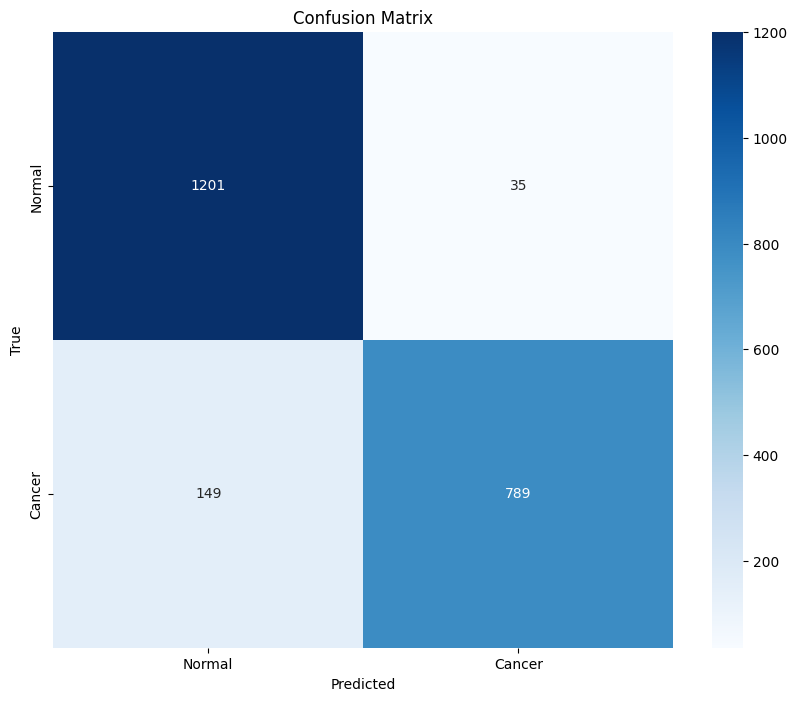

In [17]:
avg_loss, accuracy, precision, recall, f1, all_labels, all_preds = evaluate_model(model, test_loader, criterion)

# Print the evaluation metrics
print(f"Average Loss: {avg_loss}")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot the confusion matrix
plot_confusion_matrix(all_labels, all_preds)

In [19]:
print(classification_report(all_labels, all_preds, target_names=['Healthy', 'Unhealthy']))

              precision    recall  f1-score   support

     Healthy       0.89      0.97      0.93      1236
   Unhealthy       0.96      0.84      0.90       938

    accuracy                           0.92      2174
   macro avg       0.92      0.91      0.91      2174
weighted avg       0.92      0.92      0.91      2174

